##**05.콘텐츠 기반 필터링 실습 - TMDB 5000 영화 데이터 세트**

TMDB 5000 영화 데이터 세트 
- 유명한 영화 데이터 정보 사이트인 IMDB의 많은 영화 중 주요 5000개 영화에 대한 메타 정보를 새롭게 가공해 제공하는 데이터 세트



###**장르 속성을 이용한 영화 콘텐츠 기반 필터링**
**콘텐츠 기반 필터링** : 사용자가 특정 영화를 감상하고 그 영화를 좋아했다면 그 영화와 비슷한 특성/속성, 구성요소 등을 가진 다른 영화를 추천하는 것

-> 영화 장르 속성을 기반으로 한 콘텐츠 기반 필터링 추천 시스템
- 장르 칼럼 값의 유사도를 비교한 뒤 그 중 높은 평점을 가지는 영화를 추천하는 방식


###**데이터 로딩 및 가공**


In [ ]:
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')

movies = pd.read_csv("/content/drive/MyDrive/ESAA/23-1/TMDB5000/tmdb_5000_movies.csv")
print(movies.shape)
movies.head(1)

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""sp...",en,Avatar,"In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, ...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289}, {""name"": ""Twentieth Century Fox Film Corporatio...","[{""iso_3166_1"": ""US"", ""name"": ""United States of America""}, {""iso_3166_1"": ""GB"", ""name"": ""United ...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,Enter the World of Pandora.,Avatar,7.2,11800


- 4803개의 레코드와 20개의 피처로 구성
- 영화 제목, 개요, 인기도, 평점, 투표 수, 예산, 키워드 등 영화에 대한 다양한 메타 정보를 가지고 있음
- 콘텐츠 기반 필터링 추천 분석에 사용할 주요 칼럼만 추출해 새롭게 df 만들기
  - id, genres, vote_average, vote_count, popularity, keywords, overview

In [ ]:
movies_df = movies[['id', 'title', 'genres', 'vote_average', 'vote_count', 'popularity', 'keywords', 'overview']]

> 주의해야 할 칼럼
- genres, keywords : 리스트 내부에 여러 개의 딕셔너리가 있는 형태의 문자열로 표기

In [ ]:
pd.set_option('max_colwidth',100)
movies_df[['genres','keywords']][:1]

,genres,keywords
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""sp..."


- 장르 칼럼은 여러 개의 개별 장르 데이터를 가지고 있고, 개별 장르 명칭은 딕셔너리의 key인 'name'으로 추출할 수 있음
- `literal_eval()` : list[dict1, dict2] 객체로 만들 수 있음

In [ ]:
from ast import literal_eval
movies_df['genres']= movies_df['genres'].apply(literal_eval)
movies_df['keywords']=movies_df['keywords'].apply(literal_eval)

- 장르 칼럼은 문자열이 아니라 실제 리스트 내부에 여러 장르 딕셔너리로 구성된 객체를 가짐
- 장르 칼럼에서 장르명만 리스트 객체로 추출

In [ ]:
movies_df['genres'] = movies_df['genres'].apply(lambda x : [y['name'] for y in x])
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : [y['name'] for y in x])
movies_df[['genres','keywords']][:1]

,genres,keywords
0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colony, society, space travel, futuristic, romance, spa..."


###**장르 콘텐츠 유사도 측정**
genres 칼럼을 기반으로 하는 콘텐츠 기반 필터링
- 문자열로 변환된 genres 칼럼을 Count 기반으로 피처 벡터화 변환한다.
- genres 문자열을 피처 벡터화 행렬로 변환한 데이터 세트를 코사인 유사도를 통해 비교한다. 이를 위해 데이터 세트의 레코드별로 타 레코드와 장르에서 코사인 유사도 값을 가지는 객체를 생성한다.
- 장르 유사도가 높은 영화 중에 평점이 높은 순으로 영화를 추천한다.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

#CountVectorizer를 적용하기 위해 공백문자로 word 단위가 구분되는 문자열로 변환
movies_df['genres_literal'] = movies_df['genres'].apply(lambda x : (' '.join(x)))
count_vect = CountVectorizer(min_df = 0, ngram_range=(1,2))
genre_mat = count_vect.fit_transform(movies_df['genres_literal'])
print(genre_mat.shape)

(4803, 276)


- CountVectorizer로 변환해 4803개의 레코드와 276개의 개별 단어 피처로 구성된 피처 벡터 행렬이 만들어짐
- 사이킷런의 cosine_similarity()를 이용해 코사인 유사도 계산

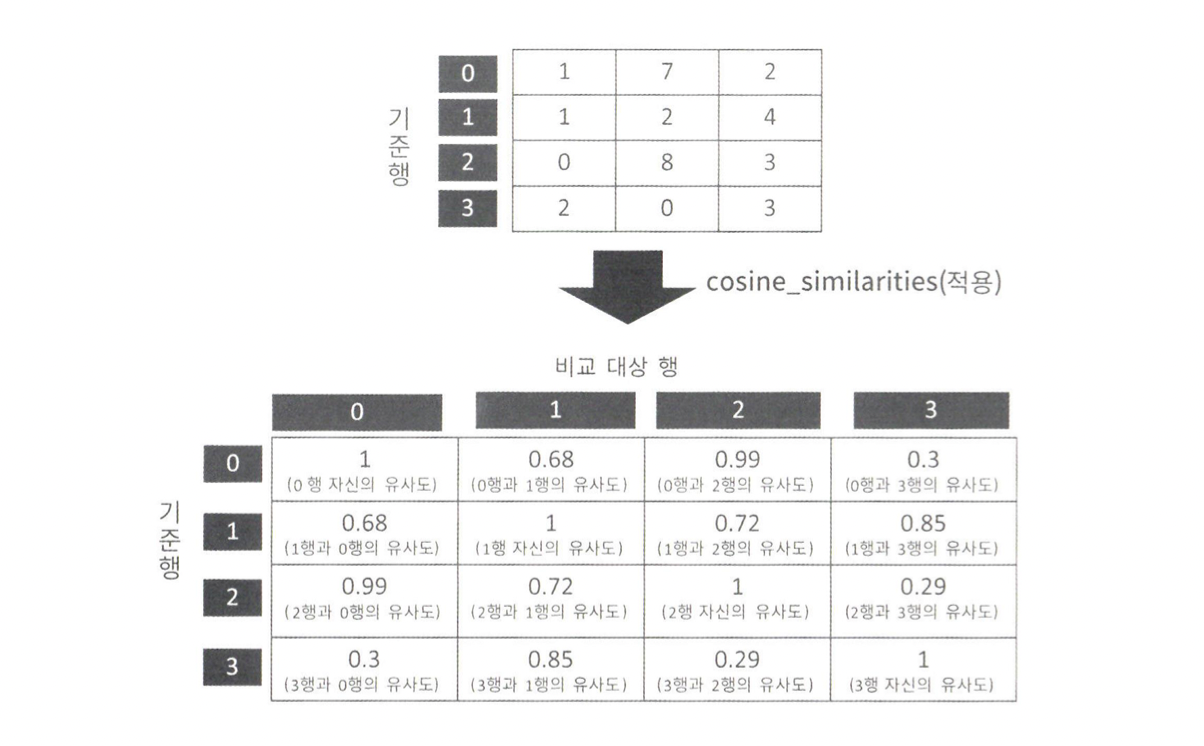

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

genre_sim = cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape)
print(genre_sim[:1])

(4803, 4803)
[[1.         0.59628479 0.4472136  ... 0.         0.         0.        ]]


- cosine_similarities() 호출로 생성된 genre_sim 객체는 movies_df의 genre_literal 칼럼을 피처 벡터화한 행렬 데이터의 행별 유사도 정보를 가지고 있음
- movies_df의 개별 레코드에 대해 가장 장르 유사도가 높은 순으로 다른 레코드를 추출해야 함 : genre_sim 객체를 이용
  - genre_sim 기준 행별로 비교 대상이 되는 행의 유사도 값이 높은 순으로 정렬된 행렬의 위치 인덱스 값을 추출
  - 값이 높은 순으로 정렬된 비교 대상 행의 유사도 값이 아니라 비교 대상 행의 위치 인덱스임
  - `argsort()[:,::-1]` 이용 : 유사도가 높은 순으로 정리된 genre_sim 객체의 비교 행 위치 인덱스 값을 간편하게 얻을 수 있음


In [ ]:
genre_sim_sorted_ind = genre_sim.argsort()[:,::-1]
print(genre_sim_sorted_ind[:1])

[[   0 3494  813 ... 3038 3037 2401]]


- 0번 레코드의 경우 자신인 0번 레코드를 제외하면 3494번 레코드가 가장 유사도가 높고, 그 다음이 813번 레코드이며, 가장 유사도가 낮은 레코드는 2401번 레코드이다.
- `genre_sim_sorted_ind` : 각 레코드의 장르 코사인 유사도가 가장 높은 순으로 정렬된 타 레코드의 위치 인덱스 값을 가지고 있음
  - 이를 이용해 특정 레코드와 코사인 유사도가 높은 다른 레코드 추출 가능

###**장르 콘텐츠 필터링을 이용한 영화 추천**


In [ ]:
def find_sim_movie(df, sorted_ind, title_name, top_n = 10):
  #인자로 입력된 movies_df DataFrame에서 'title' 칼럼이 입력된 title_name 값인 DataFrame 추출
  title_movie = df[df['title']== title_name]

  #title_named를 가진 DataFrame의 index 객체를 ndarray로 반환하고 
  #sorted_ind 인자로 입력된 genre_sim_sorted_ind 객체에서 유사도 순으로 top_n 개의 index 추출
  title_index = title_movie.index.values
  similar_indexes = sorted_ind[title_index, :(top_n)]

  #추출된 top_n index 출력. top_n index는 2차원 데이터임
  #dataframe 에서 index로 사용하기 위해서 1차원 array로 변경
  print(similar_indexes)
  similar_indexes = similar_indexes.reshape(-1)

  return df.iloc[similar_indexes]

- find_sim_movie() 함수를 이용해 영화'대부'와 장르별로 유사한 영화 10개를 추천

In [ ]:
similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather',10)
similar_movies[['title','vote_average']]

[[2731 1243 3636 1946 2640 4065 1847 4217  883 3866]]


,title,vote_average
2731,The Godfather: Part II,8.3
1243,Mean Streets,7.2
3636,Light Sleeper,5.7
1946,The Bad Lieutenant: Port of Call - New Orleans,6.0
2640,Things to Do in Denver When You're Dead,6.7
4065,Mi America,0.0
1847,GoodFellas,8.2
4217,Kids,6.8
883,Catch Me If You Can,7.7
3866,City of God,8.1


- '대부 2편(The Godfather: Part 2)'이 가장 먼저 추천됨
- 낯선 영화도 많다 -> 개선이 필요함


vote_average 사용

In [ ]:
movies_df[['title','vote_average','vote_count']].sort_values('vote_average',ascending=False)[:10]

,title,vote_average,weighted_vote,vote_count
3519,Stiff Upper Lips,10.0,12.211283,1
4247,Me You and Five Bucks,10.0,18.330249,2
4045,"Dancer, Texas Pop. 81",10.0,12.211283,1
4662,Little Big Top,10.0,12.211283,1
3992,Sardaarji,9.5,18.327563,2
2386,One Man's Hero,9.3,18.326488,2
2970,There Goes My Baby,8.5,18.322189,2
1881,The Shawshank Redemption,8.5,50000.492863,8205
2796,The Prisoner of Zenda,8.4,73.348451,11
3337,The Godfather,8.4,35915.162671,5893


- 평가 횟수가 매우 적은 경우 왜곡된 평점 데이터가 나옴
- 평점에 평가 횟수를 가중치로 부여한 새로운 평가 방식 사용

IMDB에서는 평가 횟수에 대한 가중치가 부여된 평점(Weighted Rating) 방식 사용
```
가중 평점(Weighted Rating) = (v/(v+m))*R + (m/(v+m))*C

v : 개별 영화에 평점을 투표한 횟수
m : 평점을 부여하기 위한 최소 투표 횟수
R : 개별 영화에 대한 평균 평점
C : 전체 영화에 대한 평균 평점
```
m 값은 전체 투표 횟수에서 상위 60%에 해당하는 횟수를 기준으로 정함



In [ ]:
C = movies_df['vote_average'].mean()
m = movies_df['vote_count'].quantile(0.6)
print('C:',round(C,3),'m:',round(m,3))

C: 6.092 m: 370.2


- 기존 평점을 새로운 가중 평점으로 변경하는 함수를 생성하고 이를 이용해 새로운 평점 정봉ㄴ vote_weighted 생성

In [ ]:
percentile = 0.6
m = movies['vote_count'].quantile(percentile)
C = movies['vote_average'].mean()

def weighted_vote_average(record):
  v = record['vote_count']
  R = record['vote_average']

  return ((v/(v+m))*R)+((m/(m+v))*C)

movies_df['weighted_vote'] = movies.apply(weighted_vote_average, axis=1)

- weighted_vote 상위 10개

In [ ]:
movies_df[['title','vote_average','weighted_vote','vote_count']].sort_values('weighted_vote',ascending=False)[:10]

,title,vote_average,weighted_vote,vote_count
1881,The Shawshank Redemption,8.5,8.396052,8205
3337,The Godfather,8.4,8.263591,5893
662,Fight Club,8.3,8.216455,9413
3232,Pulp Fiction,8.3,8.207102,8428
65,The Dark Knight,8.2,8.136930,12002
1818,Schindler's List,8.3,8.126069,4329
3865,Whiplash,8.3,8.123248,4254
809,Forrest Gump,8.2,8.105954,7927
2294,Spirited Away,8.3,8.105867,3840
2731,The Godfather: Part II,8.3,8.079586,3338


- 새롭게 정의된 평점 기준에 따라 영화를 추천
- 장르 유사성이 높은 영화를 top_n의 2배수만큼 후보군으로 선정한 뒤 weighted_vote 칼럼 값이 높은 순으로 top_n만큼 추출하는 방식으로 변경

In [ ]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
  title_movie = df[df['title']==title_name]
  title_index = title_movie.index.values

  #top_n의 2배에 해당하는 장르 유사성이 높은 인덱스 추출
  similar_indexes = sorted_ind[title_index, :(top_n*2)]
  similar_indexes = similar_indexes.reshape(-1)
  #기준 영화 인덱스는 제외
  similar_indexes = similar_indexes[similar_indexes != title_index]

  #top_n의 2배에 해당하는 후보군에서 weighted_vote가 높은 순으로 top_n만큼 추출
  return df.iloc[similar_indexes].sort_values('weighted_vote',ascending=False)[:top_n]

similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', 10)
similar_movies[['title','vote_average','weighted_vote']]

,title,vote_average,weighted_vote
2731,The Godfather: Part II,8.3,8.079586
1847,GoodFellas,8.2,7.976937
3866,City of God,8.1,7.759693
1663,Once Upon a Time in America,8.2,7.657811
883,Catch Me If You Can,7.7,7.557097
281,American Gangster,7.4,7.141396
4041,This Is England,7.4,6.739664
1149,American Hustle,6.8,6.717525
1243,Mean Streets,7.2,6.626569
2839,Rounders,6.9,6.530427
